<a href="https://colab.research.google.com/github/Mogreine29/HandsOnAI_2/blob/main/ModelTesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras_preprocessing import text,sequence
from tensorflow import keras
import pandas as pd
import re
import string
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Skip this if Drive not needed

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive/Challenge2

Mounted at /content/drive
/content/drive/My Drive/Challenge2


Load a model here

In [3]:
path_to_load = '/content/drive/MyDrive/Challenge2/model6'

In [4]:
model = keras.models.load_model(path_to_load)

Reading data for testing

In [16]:
df_test = pd.read_csv('/content/drive/MyDrive/Challenge2/fake_test.csv')
df_test = df_test.drop(['Unnamed: 0', 'target_name'], axis = 1)

In [17]:
STOPWORDS = set(stopwords.words('french'))

def cleaner(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)

    text = ' '.join(word for word in text.split() if word not in STOPWORDS)   
    return text

df_test['data'] = df_test['data'].apply(cleaner)

In [18]:
x_test = df_test["data"]
y_test = df_test["label"]

In [19]:
max_features = 10000
maxlen = 512
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_test)
tokenized_test = tokenizer.texts_to_sequences(x_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

In [20]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

16/16 [==============================] - 5s 302ms/step - loss: 0.4315 - accuracy: 0.8457
Accuracy of the model on Testing Data is -  84.5678985118866 %


In [10]:
pred = model.predict(X_test)

16/16 [==============================] - 5s 300ms/step


In [11]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

In [12]:
print(classification_report(list(y_test), np.round(pred).astype(int), target_names = ['Not Fake','Fake']))

              precision    recall  f1-score   support

    Not Fake       0.82      0.81      0.81       272
        Fake       0.76      0.77      0.76       214

    accuracy                           0.79       486
   macro avg       0.79      0.79      0.79       486
weighted avg       0.79      0.79      0.79       486



In [23]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,np.round(pred).astype(int))
cm
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])

Text(69.0, 0.5, 'Actual')

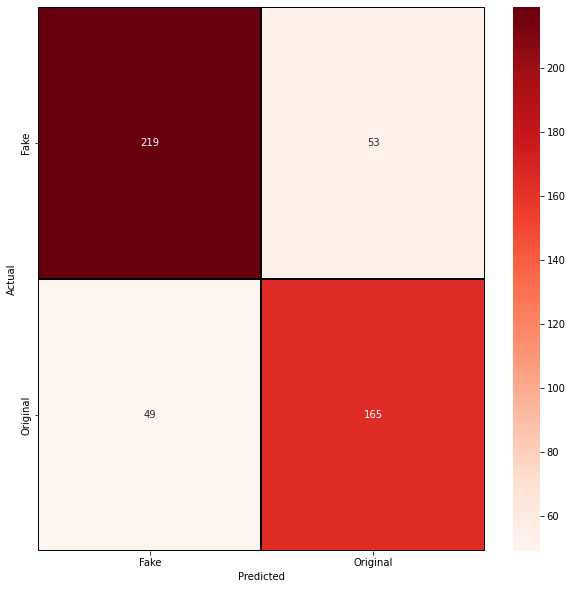

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Reds", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")